# LLM's Perception of Hedging Words

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import openai
import os
import re
import time
import concurrent.futures
import threading
from functools import partial

## Recreate the Experiment with LLMs

For experiment implementation details, refer to https://arxiv.org/abs/2407.15814.

In [ ]:
model_name = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"

In [ ]:
survey_hedging_phrase = [
    "believes the chances are slight that",
    "believes it is highly unlikely",
    "believes there is almost no chance",
    "believes there is little chance",
    "believes it is probably not that",
    "believes it is unlikely that",
    "believes it is improbable that",
    "doubts",
    "believes it is about even that",
    "believes it is better than even",
    "believes that probably"
    "believes",
    "believes it is likely",
    "believes it is probable",
    "believes there is a very good chance",
    "believes it is highly likely",
    "believes it is almost certain"
]

survey_hedging_words = [
    "Chances are Slight",
    "Highly Unlikely",
    "Almost no Chance",
    "Little Chance",
    "Probably Not",
    "Unlikely",
    "Improbable",
    "We Doubt",
    "About Even",
    "Better than Even",
    "Probably",
    "We Believe",
    "Likely",
    "Probable",
    "Very Good Chance",
    "Highly Likely",
    "Almost Certain"
]

In [3]:
paper_hedging_words = [
    "almost certain", "highly likely", "very likely", "probable",
    "somewhat likely", "possible", "uncertain", "somewhat unlikely",
    "unlikely", "not likely", "doubtful", "very unlikely", "highly unlikely"
]

In [4]:
female_names = ["Amanda", "Bonnie", "Camille", "Catherine", "Cheri", "Ethel", "Gabriela", "Jacquelyn", "Jessica", "Laura", "Olga", "Roxanne", "Silvia", "Tara", "Violet"]
male_names = ["Brendan", "Bruce", "David", "Gary", "Isaac", "Jeffery", "Joey", "Johnnie", "Kenny", "Lance", "Marco", "Mike", "Nathan", "Nick", "Raul"]

In [5]:
statements = [
    "they will buy a new watch this Thanksgiving weekend.",
    "they will be offered a promotion this fall.",
    "the company will have another round of layoffs by mid-July.",
    "there will be vegetarian options at the barbecue.",
    "they will visit New York over winter break.",
    "the restaurant near their apartment accepts reservations.",
    "the new museum is offering complimentary admission.",
    "there is a yoga studio within 2 miles of their workplace.",
    "there are more than eighty students in the auditorium right now.",
    "the temperature in the office is at least 72 degrees Fahrenheit.",
    "their boss owns a blue car.",
    "their friend has a leather jacket.",
    "their cousin has a vegetable garden.",
    "their classmate owns a guitar.",
    "their boss has a stereo amplifier.",
    "their cousin prefers spinach over broccoli.",
    "their boss prefers coffee over tea.",
    "their friend prefers running over cycling.",
    "their neighbor prefers the beach over the mountains.",
    "their coworker prefers reading books over watching movies."
]

In [7]:
paper_all_sentences = {}

for hedge in paper_hedging_words:
    for name in female_names + male_names:
        for statement in statements:
            paper_all_sentences[f"""{name} believes it is {hedge} that {statement}"""] = hedge

In [ ]:
client = openai.OpenAI(api_key=os.environ["TOGETHER_API_KEY"], base_url="https://api.together.xyz/v1")
MAX_BACKOFF = 10
def sample(prompt, model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"):
    trial = 0
    while True:
        try:
            response = client.chat.completions.create(
                model=model,
                temperature=0,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=500
            )
            return response.choices[0].message.content.strip()
        
        except Exception as e:
            backoff = min(2**trial, MAX_BACKOFF)
            print(
                f"Rate limit exception so wait and retry {trial} after {backoff} sec",
                e,
            )
            time.sleep(backoff)
            trial += 1

In [9]:
def get_query_template(sentence):
    return f"""{sentence} From their perspective, considering the use of hedging words, what is the probability (from 0 to 100) that the statement is true? Concisely provide your response only in the following format: Probability: [0-100]%"""

In [ ]:
paper_probability_map = {h : []  for h in paper_hedging_words}
paper_df = []
lock = threading.Lock()
MAX_WORKERS = 70

In [ ]:
##### Change the model name here

def process_sentence(item: tuple, probability_map: dict, df: list[pd.DataFrame]):
    sentence, hedge = item
    response = sample(get_query_template(sentence), model_name)
    df_new_row = {"prompt": sentence, "hedging_word": hedge, "response": response}
    pattern = r"\b(?:Probability|Prob(?:\.|ability)?|P)\s*[:=]?\s*(\d+)%"
    match = re.search(pattern, response, re.IGNORECASE)
    if match:
        probability = int(match.group(1))
        df_new_row["extracted_confidence"] = probability
        with lock:
            probability_map[hedge].append(probability)
        print(hedge, probability, len(probability_map[hedge]))
    df.append(pd.DataFrame(df_new_row, index=[0]))

In [12]:
# should incorporate parallelism to speed it up
paper_fn = partial(process_sentence, probability_map=paper_probability_map, df=paper_df)
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    executor.map(paper_fn, paper_all_sentences.items())


almost certain 90 1
almost certain 90 2
almost certain 90 3
almost certain 90 4
almost certain 90 5
almost certain 90 6
almost certain 90 7
almost certain 90 8
almost certain 90 9
almost certain 90 10
almost certain 90 11
almost certain 90 12
almost certain 90 13
almost certain 95 14
almost certain 95 15
almost certain 95 16
almost certain 90 17
almost certain 95 18
almost certain 90 19
almost certain 95 20
almost certain 95 21
almost certain 95 22
almost certain 90 23
almost certain 90 24
almost certain 90 25
almost certain 90 26
almost certain 90 27
almost certain 90 28
almost certain 90 29
almost certain 90 30
almost certain 90 31
almost certain 90 32
almost certain 90 33
almost certain 90 34
almost certain 90 35
almost certain 90 36
almost certain 90 37
almost certain 90 38
almost certain 90 39
almost certain 90 40
almost certain 90 41
almost certain 90 42
almost certain 90 43
almost certain 90 44
almost certain 95 45
almost certain 90 46
almost certain 90 47
almost certain 95 48
a

In [13]:
survey_all_sentences = {}

for hedging_phrase, hedging_word in zip(survey_hedging_phrase, survey_hedging_words):
    for name in female_names + male_names:
        for statement in statements:
            survey_all_sentences[f"""{name} {hedging_phrase} {statement}"""] = hedging_word

In [14]:
survey_probability_map = {h : []  for h in survey_hedging_words}
survey_df = []

In [15]:
survey_fn = partial(process_sentence, probability_map=survey_probability_map, df=survey_df)
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    executor.map(survey_fn, survey_all_sentences.items())

Chances are Slight 20 1
Chances are Slight 20 2
Chances are Slight 80 3
Chances are Slight 20 4
Chances are Slight 20 5
Chances are Slight 20 6
Chances are Slight 20 7
Chances are Slight 20 8
Chances are Slight 20 9
Chances are Slight 20 10
Chances are Slight 20 11
Chances are Slight 20 12
Chances are Slight 80 13
Chances are Slight 25 14
Chances are Slight 20 15
Chances are Slight 20 16
Chances are Slight 80 17
Chances are Slight 20 18
Chances are Slight 20 19
Chances are Slight 20 20
Chances are Slight 20 21
Chances are Slight 20 22
Chances are Slight 20 23
Chances are Slight 30 24
Chances are Slight 30 25
Chances are Slight 20 26
Chances are Slight 80 27
Chances are Slight 20 28
Chances are Slight 20 29
Chances are Slight 20 30
Chances are Slight 20 31
Chances are Slight 20 32
Chances are Slight 20 33
Chances are Slight 20 34
Chances are Slight 25 35
Chances are Slight 20 36
Chances are Slight 20 37
Chances are Slight 20 38
Chances are Slight 20 39
Chances are Slight 80 40
Chances a

In [ ]:
pd.concat(paper_df, ignore_index=True).to_csv(f"{model_name.split('/')[-1]}_paper_hedging_words_results.csv")
pd.concat(survey_df, ignore_index=True).to_csv(f"{model_name.split('/')[-1]}_survey_hedging_words_results.csv")

## Plot our results/findings

### Hedging words

/var/folders/n9/q21wzh791d75mrvv_951_d_r0000gn/T/ipykernel_22564/3023334794.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, vert=False)


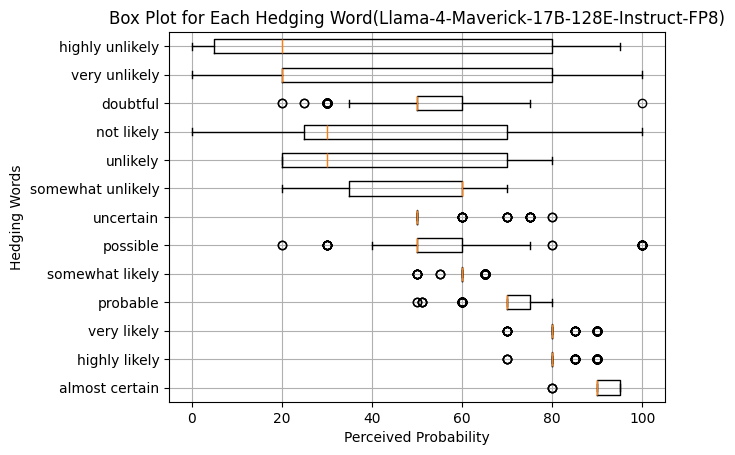

In [ ]:
labels = list(paper_probability_map.keys())
values = list(paper_probability_map.values())
plt.boxplot(values, labels=labels, vert=False)
plt.title('Box Plot for Each Hedging Word(Llama-4-Maverick-17B-128E-Instruct-FP8)')
plt.ylabel('Hedging Words')
plt.xlabel('Perceived Probability')
plt.grid(True)
plt.show()

### Survey hedging phrases

/var/folders/n9/q21wzh791d75mrvv_951_d_r0000gn/T/ipykernel_22564/1861912770.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, vert=False)


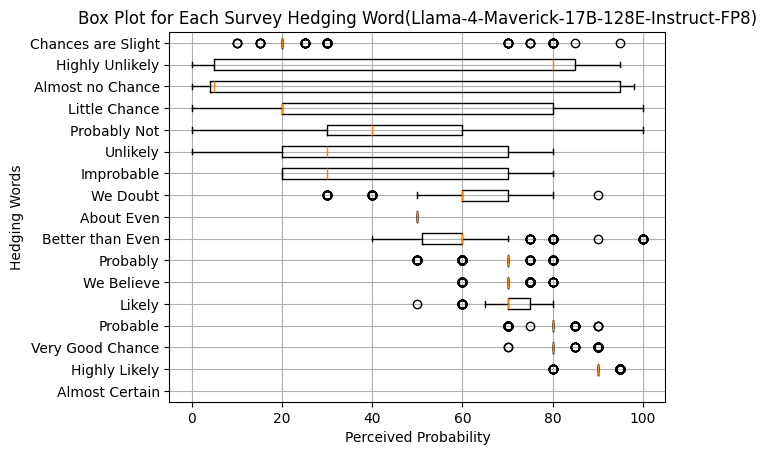

In [25]:
labels = list(reversed(list(survey_probability_map.keys())))
values = list(reversed(list(survey_probability_map.values())))
plt.boxplot(values, labels=labels, vert=False)
plt.title('Box Plot for Each Survey Hedging Word(Llama-4-Maverick-17B-128E-Instruct-FP8)')
plt.ylabel('Hedging Words')
plt.xlabel('Perceived Probability')
plt.grid(True)
plt.show()

### Percentage of no extracted confidence

In [32]:
df = pd.read_csv('paper_hedging_words_results.csv')
print(f"Paper: {df['extracted_confidence'].isna().sum()}/{len(df)}")
df = pd.read_csv('survey_hedging_words_results.csv')
print(f"Survey: {df['extracted_confidence'].isna().sum()}/{len(df)}")

Paper: 12/7800
Survey: 54/9600


In [46]:
import numpy as np
df = pd.read_csv('survey_hedging_words_results.csv')
confs = df[df["hedging_word"] == "Highly Unlikely"]["extracted_confidence"].dropna()
print(len(confs))
# print(np.var(df[]))

600
